# Gibbs Sampling for MCMC on linear model

Gibbs Sampling tactic for MCMC on linear model
1. Initialize $a^{(0)}, b^{(0)}, \tau^{(0)}$
    where $y = ax+b+\epsilon$, where the random noise $\epsilon \sim N(0,\sigma ^2 = 1/\tau)$. 
    
    For this simple model, the conditional probalitity distribution function $f(\theta | D)$, i.e. posterior distribution can be worked out analytically. Here, the probability event $\{D\}$ stands for given (seen) the collected input data set $D$ as a condition (event). Event $\{\theta\}$ stands for the case when the hyperparamters in the proposed model is descibed by $\theta$. For linear model, data set $D$ is a set of $(x,y)$ coordinates in feature-target space.

    The prior $f(\theta)$ is often assumed to be a normal distribution. The likelihood $f(D|\theta)$ is modeled as a normal due to the proposed modeling $y = ax+b+\epsilon$, where $\epsilon \sim N(0,1/\tau)$.


2. Sampling from $b^{(1)} \sim f(b| a^{(0)}, \tau^{(0)}, D)$, to obtain a sample for $b^{(1)}$.
    
    To work out the posterior we start from the prior of $b$, and its p.d.f. is 
    $$f(b) = \sqrt{\frac{\tau_0}{2\pi}}e^{-\frac{(b-\mu_0)^2\tau_0}{2}}$$
    because for the proposed model $y_i \sim N(ax_i+b,1/\tau)$, therefore
    $f(y_i,x_i| b,a,\tau) = \sqrt{\frac{\tau}{2\pi}}\exp(-\frac{\tau(y_i-ax_i-b)^2}{2})$
    $$f(D|b,a,\tau) = \prod_{i=1}^N f(y_i,x_i| b,a,\tau)$$

    As $f(b|D,a,\tau)\propto f(D|b,a,\tau) f(b)$, we can work out the conditional probability distribution
    $$
    (b|D,a,\tau)  \sim N\left(\frac{\tau_0 \mu_0+ \tau \sum\limits_{i=1}^N (y_i-ax_i)}{\tau_0+N\tau}, \frac{1}{\tau_0+N\tau}\right)
    $$


    To prove the above we only need to take the natural log of both sides of the p.d.f. and match their coefficients to a normal distribution, and in fact that is also how we obtained the mean and vairance of the posterior in the above expression.

Similarly, the other posterior are subject to
$$ (a|D,b,\tau) \sim 
N\left(\frac{\tau_1 \mu_1 + \tau \sum_{i=1}^{N} (y_i - b)x_i}{\tau_1 + \tau \sum_{i=1}^{N} x_i^2}, \frac{1}{\tau_1 + \tau \sum_{i=1}^{N} x_i^2}\right),
$$
where we have assumed $$ a \sim N(\mu_1,1/\tau_1)$$

For the posterior distribution of the variance of a normal distribution, we choose the prior to be the inverse Gamma distribution, so that the posterior is the inverse Gamma as well (This is a technique called conjugate prior). But we are using the precision variable instead of the variance, so the prior is subject to Gamma distribution.  $ \tau \sim \Gamma(\alpha, \beta)$
$$
f(\tau) = \frac{\beta}{\Gamma(\alpha) } (\beta\tau)^{\alpha-1} e^{-\beta \tau}
$$

$$
\tau \mid D, b, a \sim \Gamma \left( \alpha + \frac{N}{2}, \beta + \frac{1}{2} \sum_{i=1}^{N} (y_i - a x_i - b)^2 \right)
$$

3. Sample $a^{(1)}$ from $f (a|D,b^{(1)},\tau^{(0)})$
4. Sample $\tau^{(1)}$ from $f (\tau|D,a^{(1)}, b^{(1)})$
    Collect $(a^{(1)}, b^{(1)}, \tau^{(1)})$
5. repeat step 2-4 T times
6. after the hyperparameters are stable(balanced), take those as valid random samples, and take the sample average for the estimated hyperparameters.

This project was inspired by a tutorial by [ asia1987 ] and his video at:

https://www.bilibili.com/video/BV17D4y1o7J2?p=6&vd_source=760a7049278c172cc4351b7cf04b9c6a

which referenced notes by [ Steven Morse ] on https://stmorse.github.io/journal/gibbs.html,

one can also find similar tutorials by [ Kieran R Campbell ] at https://kieranrcampbell.github.io/posts/bayesian-linear-regression/?locale=en


In [4]:


import numpy as np

def sample_b(x,y,a,tau,mu_0,tau_0):
    N = len(x)
    precision = tau_0 + N*tau
    mean = tau_0*mu_0 + tau*np.sum(y-a*x)
    mean/= precision
    return np.random.normal(mean, 1/np.sqrt(precision))

def sample_a(x,y,b,tau,mu_1,tau_1):
    N = len(x)
    precision = tau_1+ tau*np.sum(x*x)
    mean = tau_1*mu_1 + tau*np.sum((y-b)*x)
    mean /= precision
    return np.random.normal(mean,1/np.sqrt(precision))

def sample_tau(x,y,a,b,alpha,beta):
    N = len(x)
    alpha_next = alpha + N/2
    residual = y-b-a*x
    beta_next = beta+ np.sum(residual**2)/2
    return np.random.gamma(alpha_next,1/beta_next)

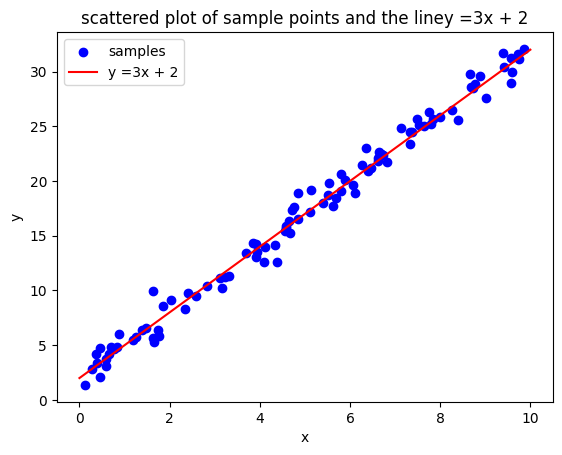

In [3]:
import matplotlib.pyplot as plt

## generate test data

a_true , b_true, tau_true = 3,2,1
N = 100
x = np.random.uniform(0,10,N)
rand_err = np.random.normal(0,1/np.sqrt(tau_true),N)
y = a_true*x + b_true + rand_err

plt.scatter(x,y,color = 'blue', label = "samples")
x_val = np.linspace(0,10,N)
y_val = a_true* x_val + b_true
plt.plot(x_val,y_val,color = 'red', label = 'y ='+str(a_true)+'x + '+str(b_true))
plt.title("scattered plot of sample points and the line"+'y ='+str(a_true)+'x + '+str(b_true))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [16]:
# initialize the starting values for Gibbs sampling of hyper-parameters:
initial = {
    'a':-0.5,
    'b': -0.2,
    'tau': 2
}

# set hyper-parameters for the priors:
hyp = {
    'mu_0': 0, 'tau_0':1,
    'mu_1': 0, 'tau_1':1,
    'alpha': 2, 'beta': 2
    
}

gibbs_sampling_steps = 2000

def gibbs (x,y,n_steps, initial,hyp):
    a = initial['a']
    b = initial['b']
    tau =initial['tau']

    for t in range (n_steps):

        b = sample_b(x,y,a,tau,hyp['mu_0'],hyp['tau_0'])
        a = sample_a(x,y,b,tau,hyp['mu_1'],hyp['tau_1'])
        tau = sample_tau(x,y,a,b,hyp['alpha'],hyp['beta'])
        yield (b,a,tau)

In [17]:
#sampling
trace = [[b,a,tau] for b,a,tau in gibbs(x,y,gibbs_sampling_steps,initial, hyp)]
trace = np.array(trace)

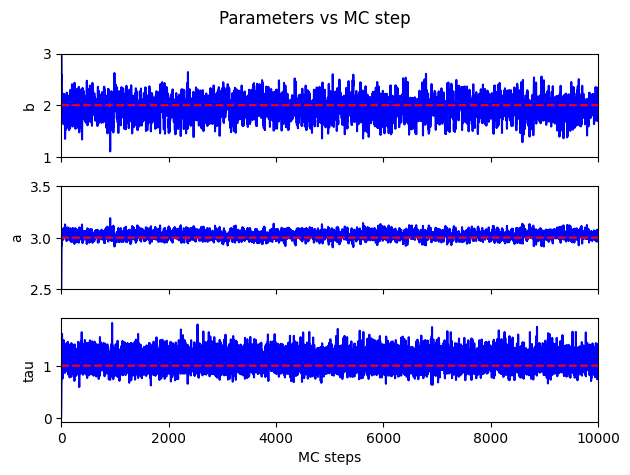

In [18]:
fig, axs = plt.subplots(3, 1, sharex=True)

x_dir_num_steps  = np.arange(gibbs_sampling_steps)
# Plot the first trace
axs[0].plot(x_dir_num_steps, trace[:,0], color='b', linestyle='-')
axs[0].plot(x_dir_num_steps, [b_true]*len(x_dir_num_steps), color='r', linestyle='dashed')
axs[0].set_ylabel('b')
axs[0].set_ylim(1, 3)

# Plot the second trace
axs[1].plot(x_dir_num_steps, trace[:,1], color='b', linestyle='-')
axs[1].plot(x_dir_num_steps, [a_true]*len(x_dir_num_steps), color='r', linestyle='dashed')
axs[1].set_ylabel('a')
axs[1].set_ylim(2.5, 3.5)

# Plot the third trace
axs[2].plot(x_dir_num_steps, trace[:,2], color='b', linestyle='-')
axs[2].plot(x_dir_num_steps, [tau_true]*len(x_dir_num_steps), color='r', linestyle='dashed')
axs[2].set_ylabel('tau')

plt.suptitle('Parameters vs MC step')
plt.xlabel('MC steps')
plt.xlim(0, gibbs_sampling_steps)
plt.tight_layout()
plt.show()

In [20]:
Start_idx = 2*trace.shape[0]//3
stable_para = trace[Start_idx:]
print("simulated hyper-parameters:\n", 
      'a = ', np.mean(stable_para[:,1]),'\n',
      'b = ', np.mean(stable_para[:, 0]), '\n',
      'tau = ', np.mean(stable_para[:,2]) 
      )

simulated hyper-parameters:
 a =  3.0250863062603357 
 b =  1.9504684636595317 
 tau =  1.1006281209661146
